# Elementary Cellular Automata (ECA)

In [1]:
using Plots;
theme(:juno)

bool(x::Int) = (x!=0); # helper function since Julia doesn't like to use ints as bools
int(x::Float64) = floor(Int, x); # converts floats to int8
int(x,y,z) = (x<<2 | y<<1 | z); # converts 3 values into the integer represented by their bitstring

function eca(N, it, rule)
    mask = 1
    world = zeros(Int8, it, N)  # Create grid
    world[1,int(N/2)] = 1;      # start with a single one in the middle        
    
    # main update loop
    for i in 1:size(world, 1)-1
        for j in 1:size(world, 2)
            b = mod1((j-1+N), N)
            e = mod1((j+1+N), N)
            if b < e
                val = int(world[i,b:e]...)
            else
                val = int(world[i,b], world[i,j], world[i,e])
            end
            if bool(rule & (mask<<val))
                world[i+1, j] = 1
            end
        end
    end
    return world;
end

eca (generic function with 1 method)

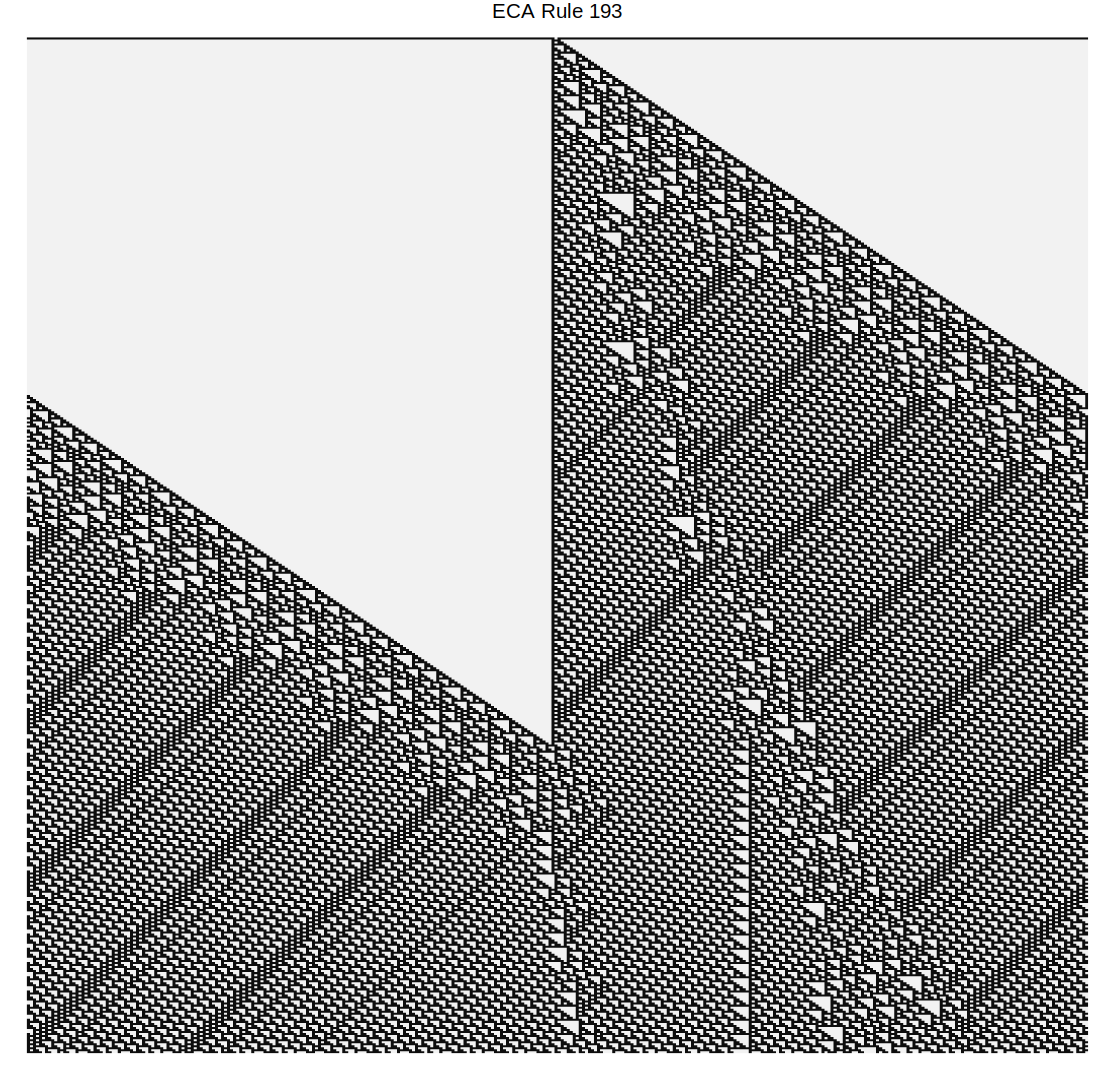

In [77]:
automaton = eca(350, 500, 193)
heatmap(1:size(automaton,2),
    1:size(automaton,1),
    reverse(automaton, dims=1),
    c = :grays,
    axis=([], false),
    legend=false,
    title="ECA Rule 193",
    size=(1100, 1080))

# Generalizing a Bit

#### There is nothing stopping us from using more than 3 parents (except maybe laziness). To enable this functionality we just have to alter the eca function a bit. Namely, we adjust one of our int() functions so that it doesn't make the assumption that we are dealing with 3 parent cells.

In [1]:
using Plots;

In [4]:
bool(x::Int) = (x!=0); # helper function since Julia doesn't like to use ints as bools
int(x::Float64) = floor(Int, x); # converts floats to int8
# below is our updated function
int(xs::Array{Int8,1}) = sum([x<<(length(xs)-i) for (i,x) in enumerate(xs)])

function eca(N::Int, it::Int, rule::Int, p::Int=1)
    mask = 1
    world = zeros(Int8, it, N)  # Create grid
    world[1,int(N/2)] = 1;      # start with a single one in the middle        
    
    # main update loop
    for i in 1:size(world, 1)-1
        for j in 1:size(world, 2)
            b = mod1((j-p+N), N)
            e = mod1((j+p+N), N)
            if b < e
                val = int(world[i,b:e])
            else
                val = int(vcat(world[i, b:N], world[i, 1:e]))
            end
            if bool(rule & (mask<<val))
                world[i+1, j] = 1
            end
        end
    end
    return world;
end

eca (generic function with 2 methods)

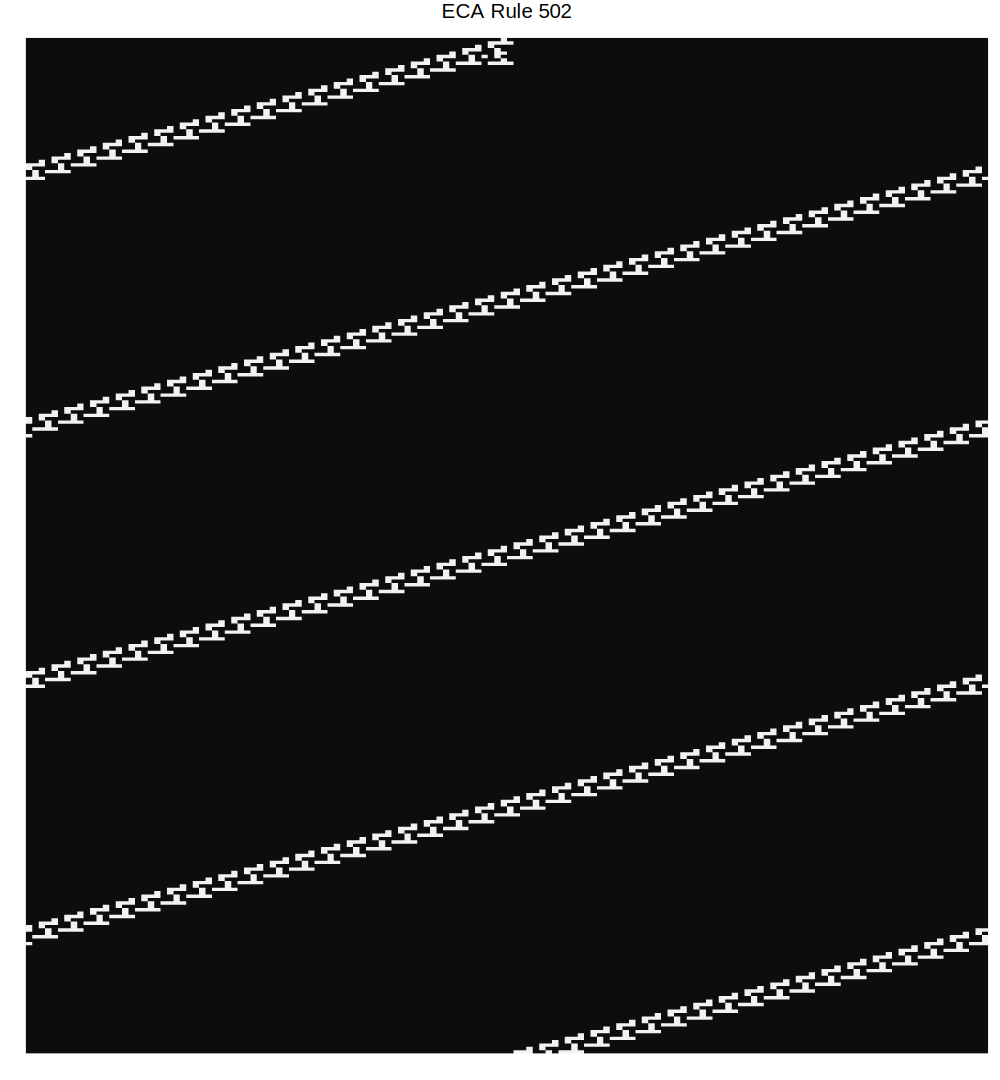

In [5]:
r = 502
automaton = eca(150, 300, r, 2)
heatmap(1:size(automaton,2),
    1:size(automaton,1),
    reverse(automaton, dims=1),
    c = :grays,
    axis=([], false),
    legend=false,
    title="ECA Rule $r",
    size=(1000, 1080))

# 3-Color Automata

#### An interesting extension of ECA involves automata with more than two possible states, e.g. each cell of the automata could take on a value in $\{0, 1, 2\}$ instad of just $\{0,1\}$. This concept can be extended to include k colors, with each rule being represented as an array of values in $[0,k-1]$ representing the base-k representation of the rule. Take, for example, the 3-color automata using rule 777 below (Wolfram, p60). Note that we are assuming a parent window size of $2p+1=3$ here.

In [57]:
# first we need to convert the rule into base-3 notation
rule = 777;
rule_base3 = reverse([parse(Int8, c) for c in string(777, base=3)]); # maybe find a more elegant approach

### Once we've done the conversion, the logic is very similar to the eca function.

In [58]:
it = 100;
N = 101

world = zeros(Int8, it, N)  # Create grid
world[1,int(N/2)] = 1;      # start with a single one in the middle        
    
# main update loop
for i in 1:size(world, 1)-1
    for j in 1:size(world, 2)
        b = mod1((j-1+N), N)
        e = mod1((j+1+N), N)
        if b < e
            val = sum(world[i,b:e]) #int(world[i,b:e]...)
        else
            val = sum([world[i,b], world[i,j], world[i,e]]) #int(world[i,b], world[i,j], world[i,e])
        end
        world[i+1, j] = rule_base3[val+1]
    end
end


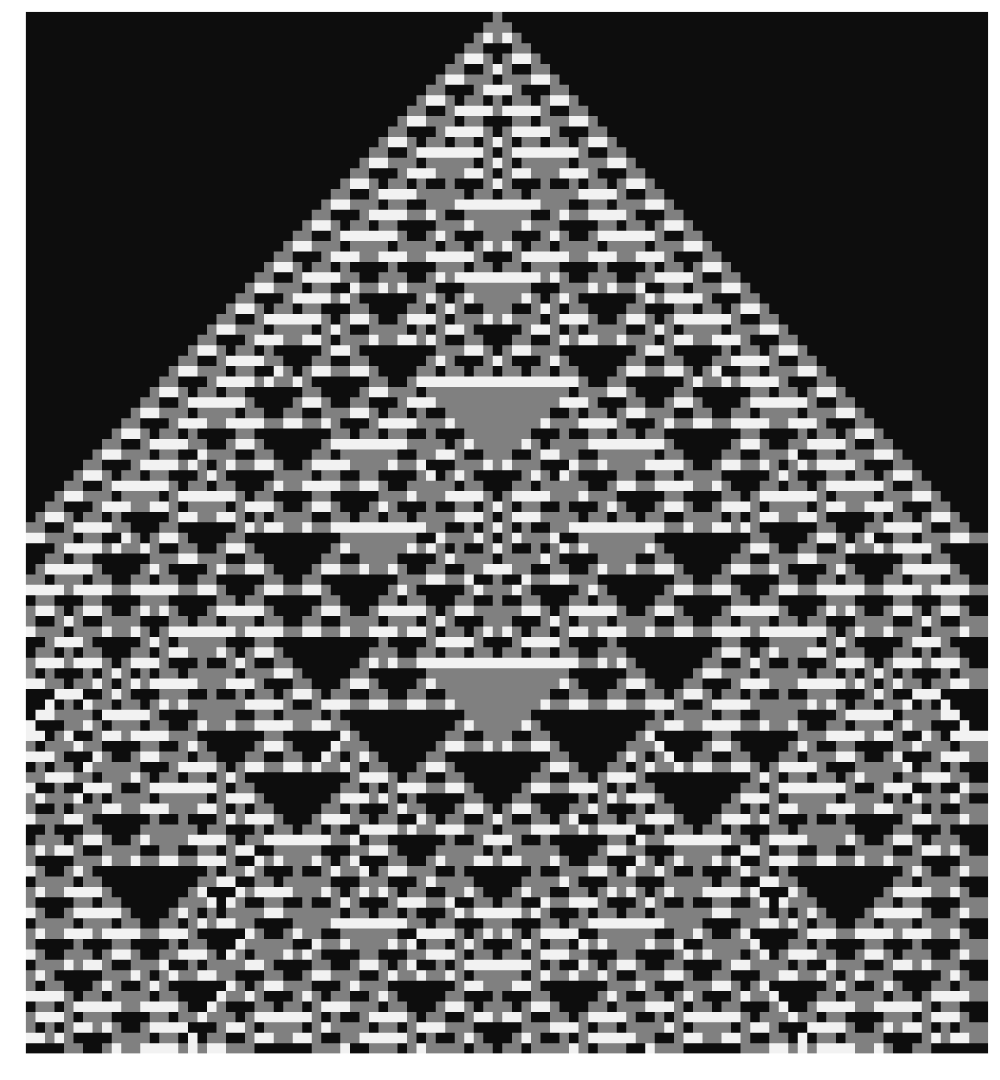

In [59]:
using ColorSchemes, Plots;
heatmap(1:size(world,2),
    1:size(world,1),
    reverse(world, dims=1),
    c = :grays,
    axis=([], false),
    legend=false,
    size=(1000, 1080))

#### So we will wrap this guy up in a handy dandy function, once again removing the asusmption that we are only dealing with a parent window of size 3.

In [29]:
function k_color(N::Int, it::Int, rule::Int; p::Int=1, k::Int=3)
    world = zeros(Int8, it, N)  # Create grid
    world[1,div(N,2)] = 1;      # start with a single one in the middle        
    rule_basek = reverse([parse(Int8, c) for c in string(rule, base=k)]) 
    
    # main update loop
    for i in 1:size(world, 1)-1
        for j in 1:size(world, 2)
            b = mod1((j-p+N), N)
            e = mod1((j+p+N), N)
            if b < e
                val = sum(world[i,b:e])
            else
                val = int(vcat(world[i, b:N], world[i, 1:e]))
            end
            world[i+1, j] = val+1 <= length(rule_basek) ? rule_basek[val+1] : 0;
        end
    end
    return 3 .- world; # broadcast subtraction to handle reversed colormap
end

k_color (generic function with 3 methods)

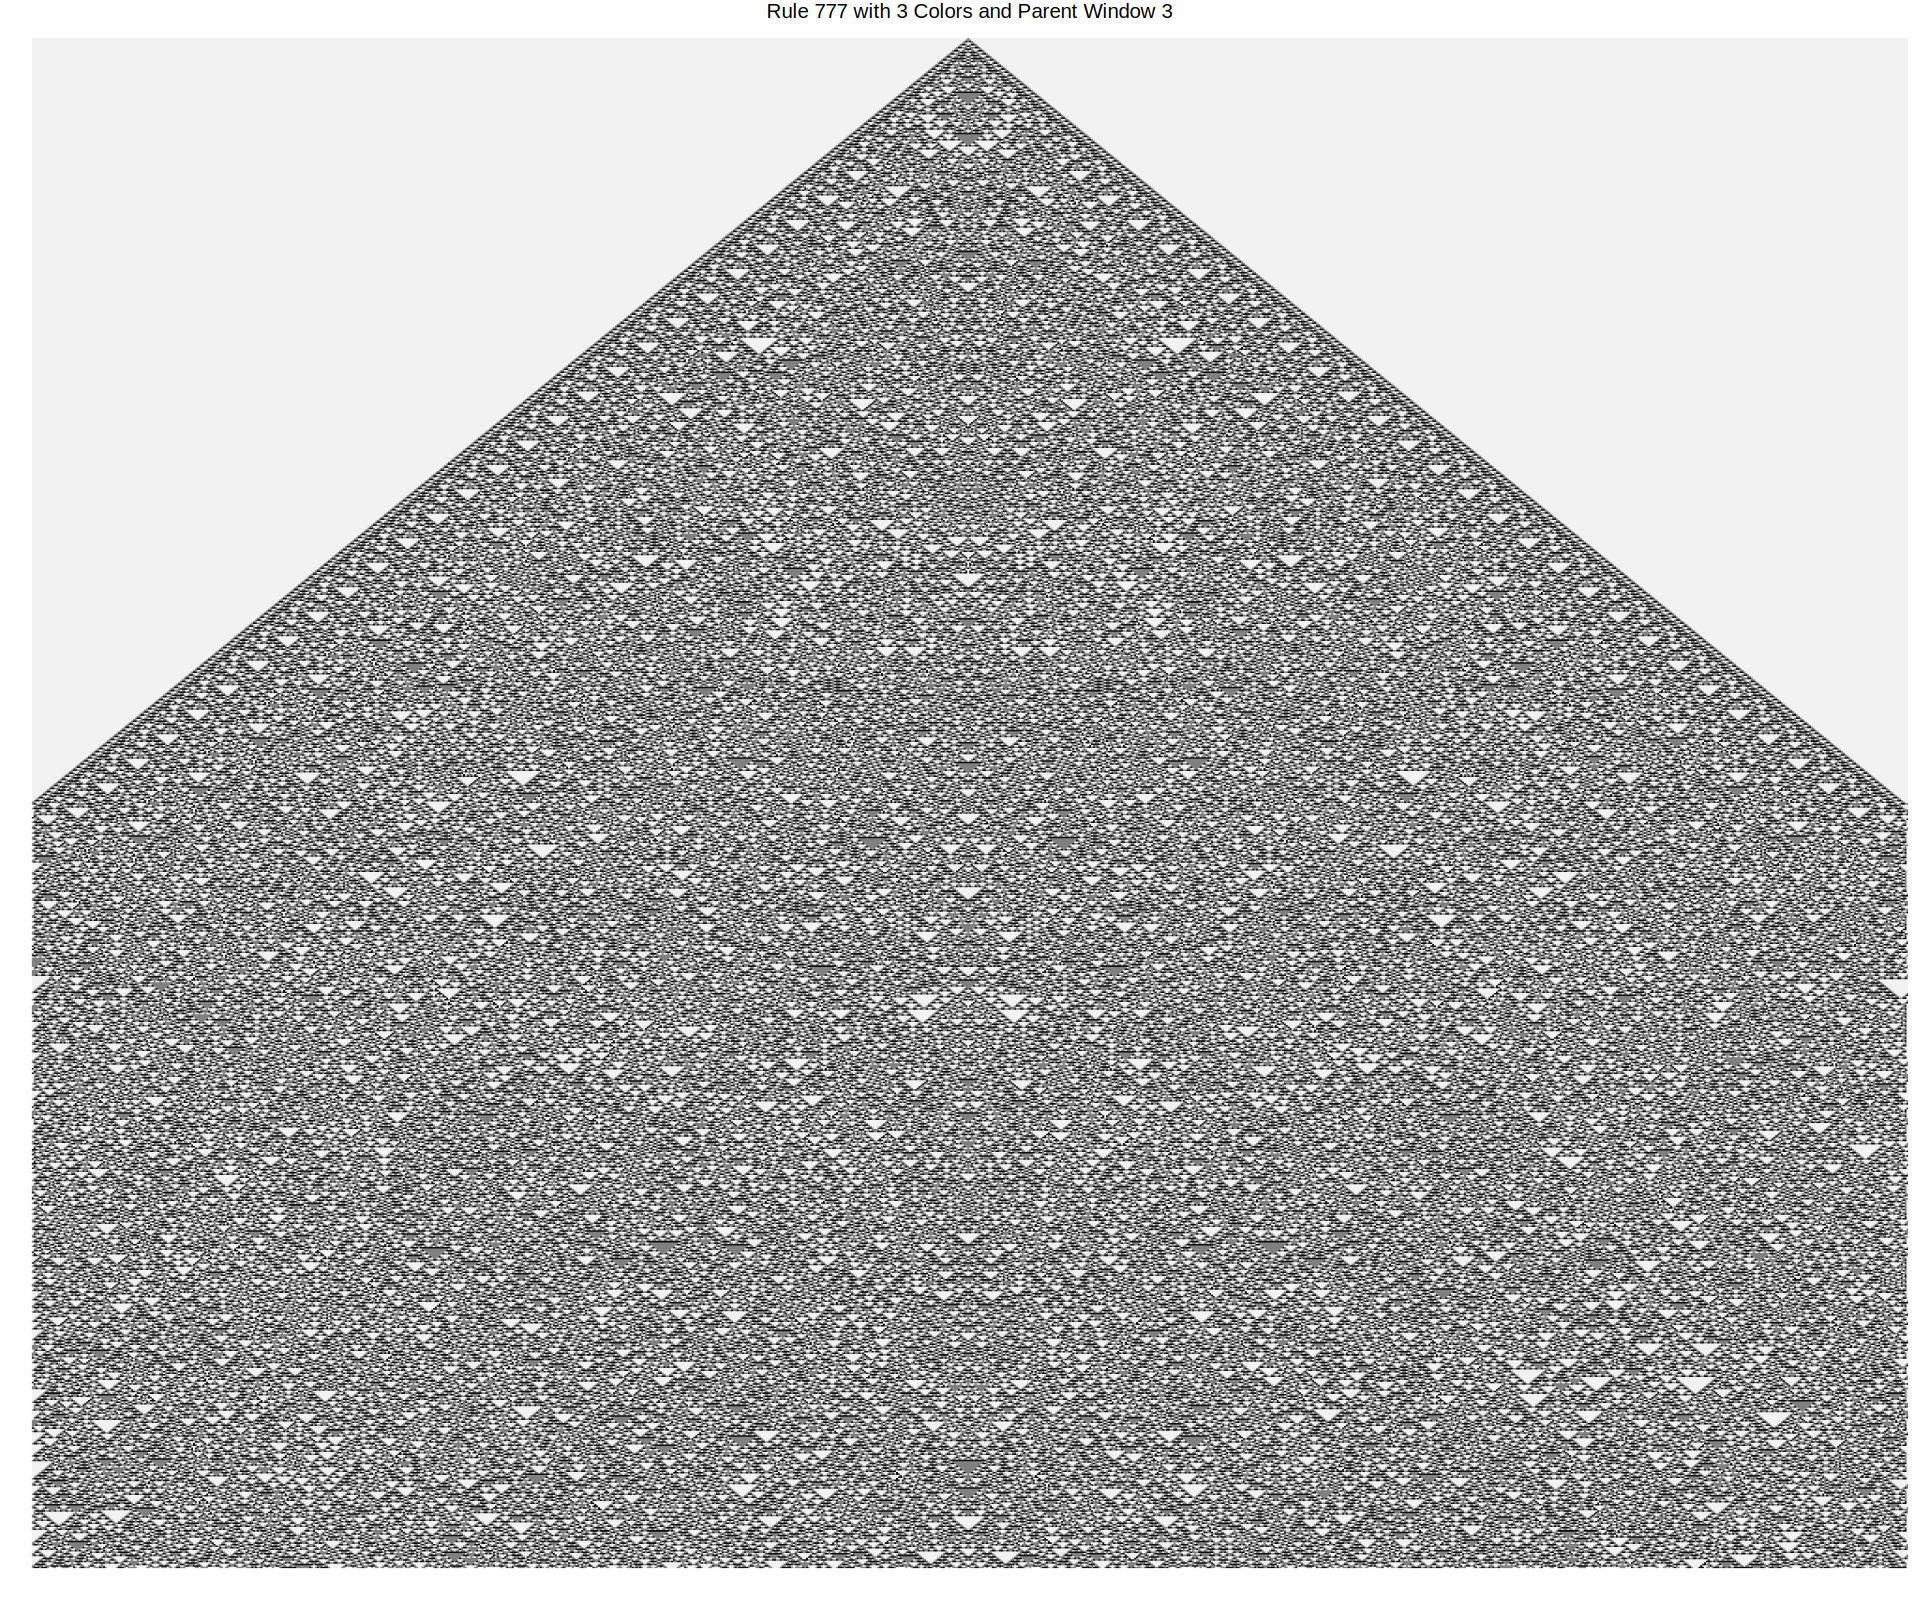

In [56]:
using ColorSchemes, Plots;
autamaton = k_color(1001, 1000, 777);
heatmap(1:size(autamaton,2),
    1:size(autamaton,1),
    reverse(autamaton, dims=1),
    c = :grays,
    axis=([], false),
    legend=false,
    size=(1920, 1600),
    title="Rule 777 with 3 Colors and Parent Window 3")

#### So it works like before, but now we can include more colors and get some fun new patterns.

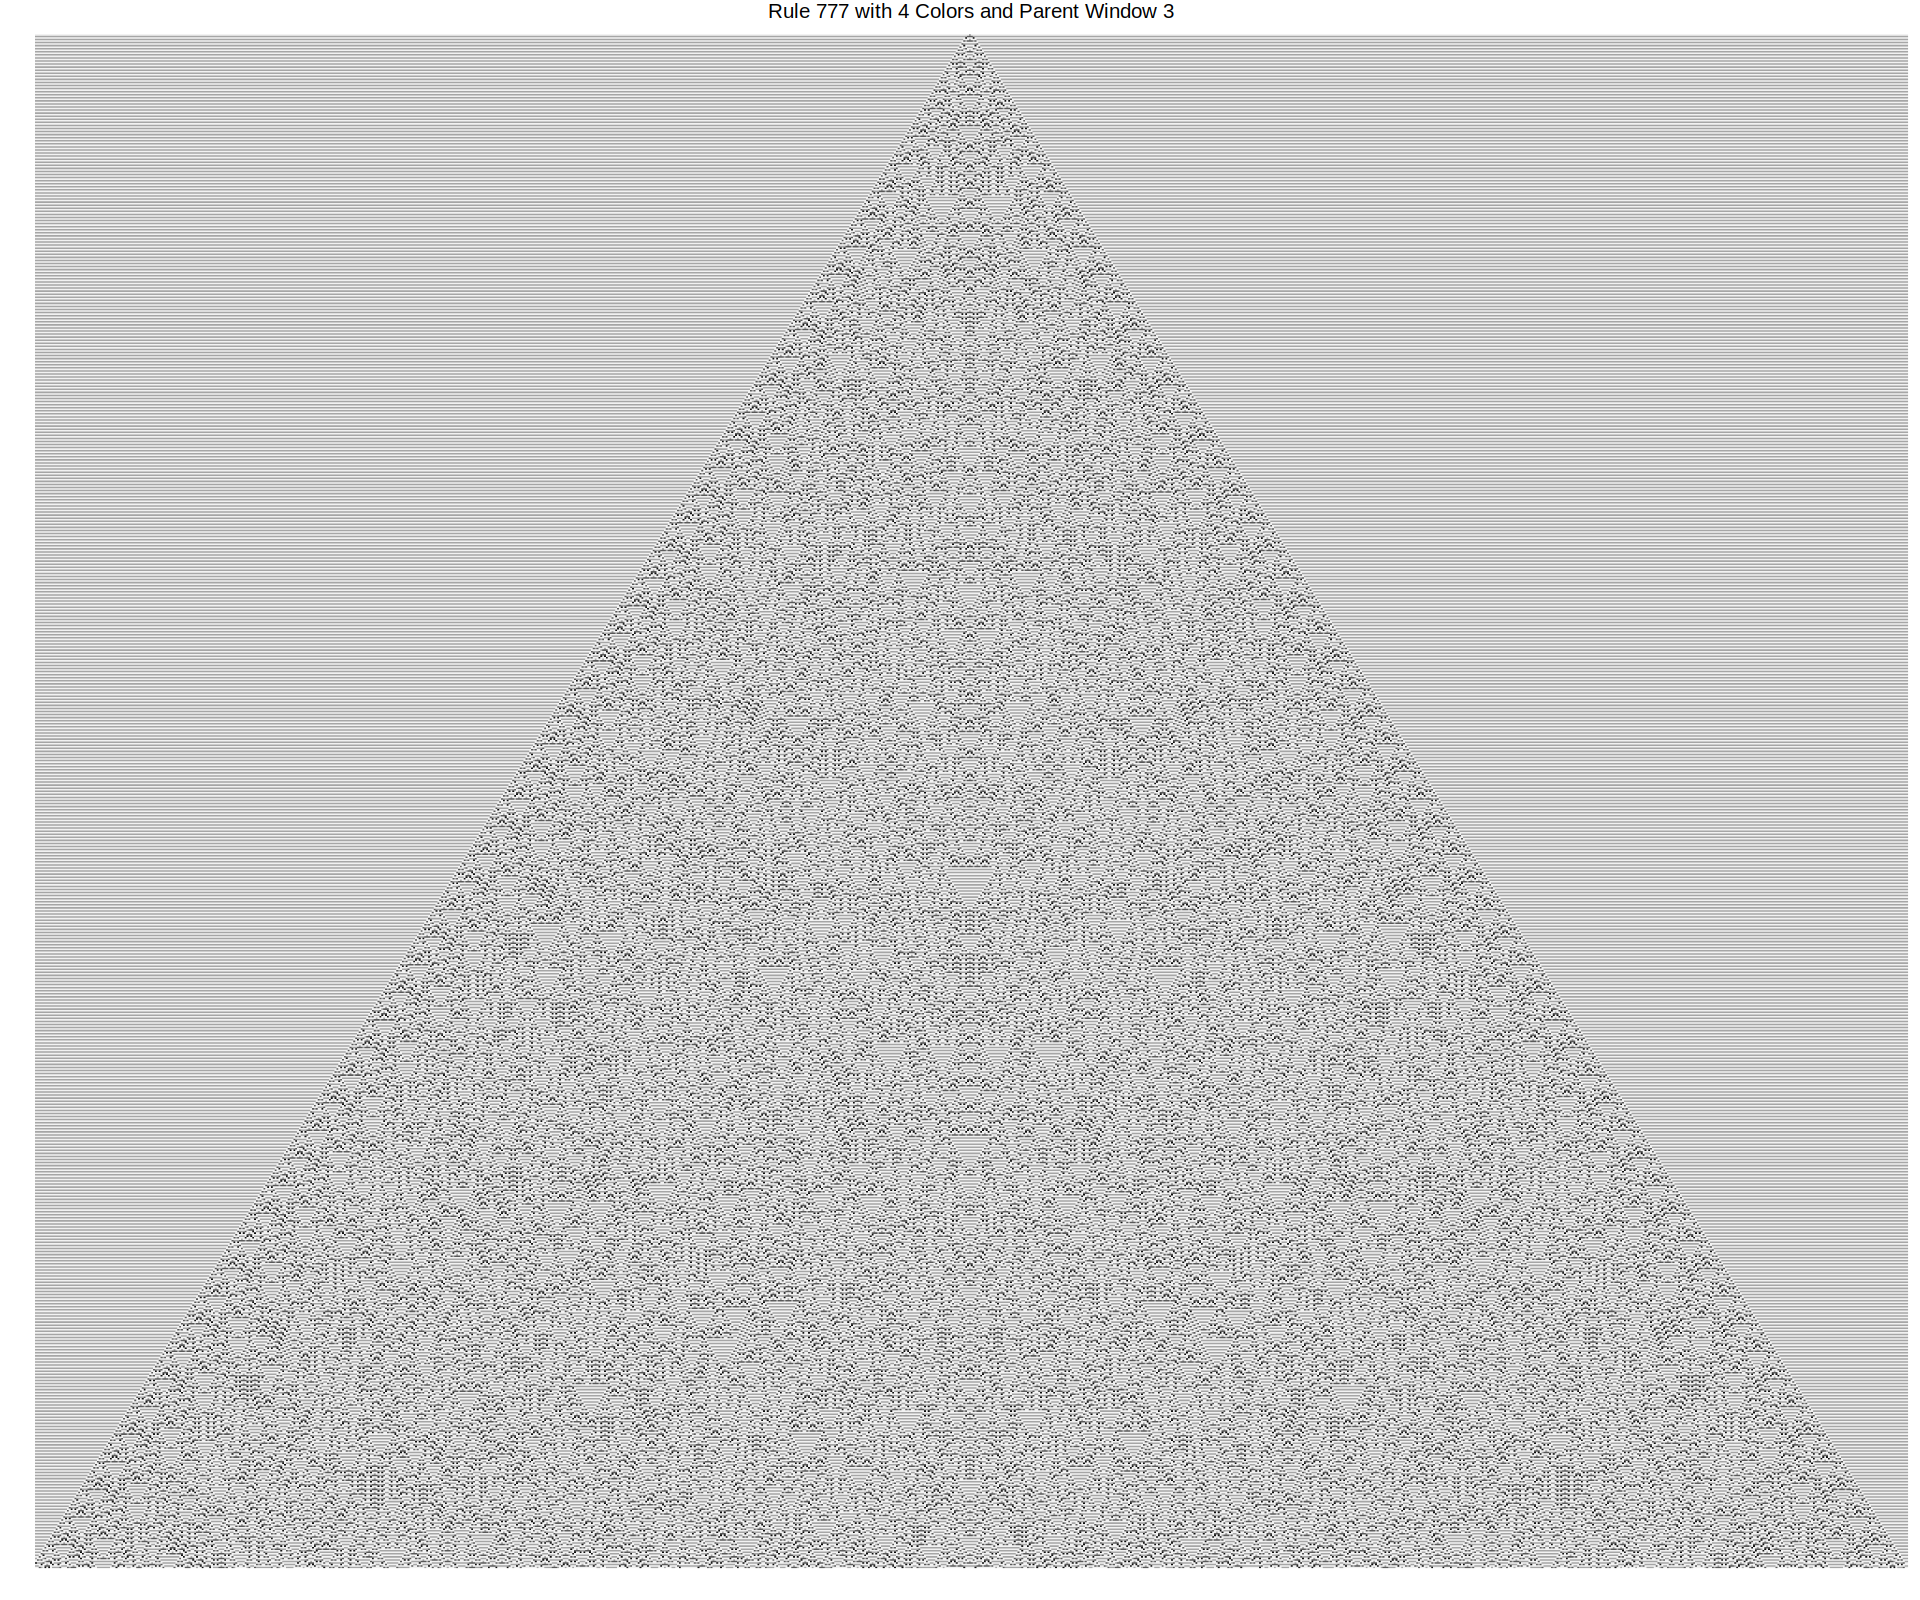

In [57]:
p = 1; # parent window 2p+1 = 3
k = 4; # k = 4 colors
autamaton = k_color(1001, 1000, 777, k=4);
heatmap(1:size(autamaton,2),
    1:size(autamaton,1),
    reverse(autamaton, dims=1),
    c = :grays,
    axis=([], false),
    legend=false,
    size=(1920, 1600),
    title="Rule 777 with $k Colors and Parent Window $(2*p+1)")

#### Interestingly enough, even when we add much more complexity to our rules in the form of larger parent windows and more colors, we find the same old patterns showing up all over the place, e.g.

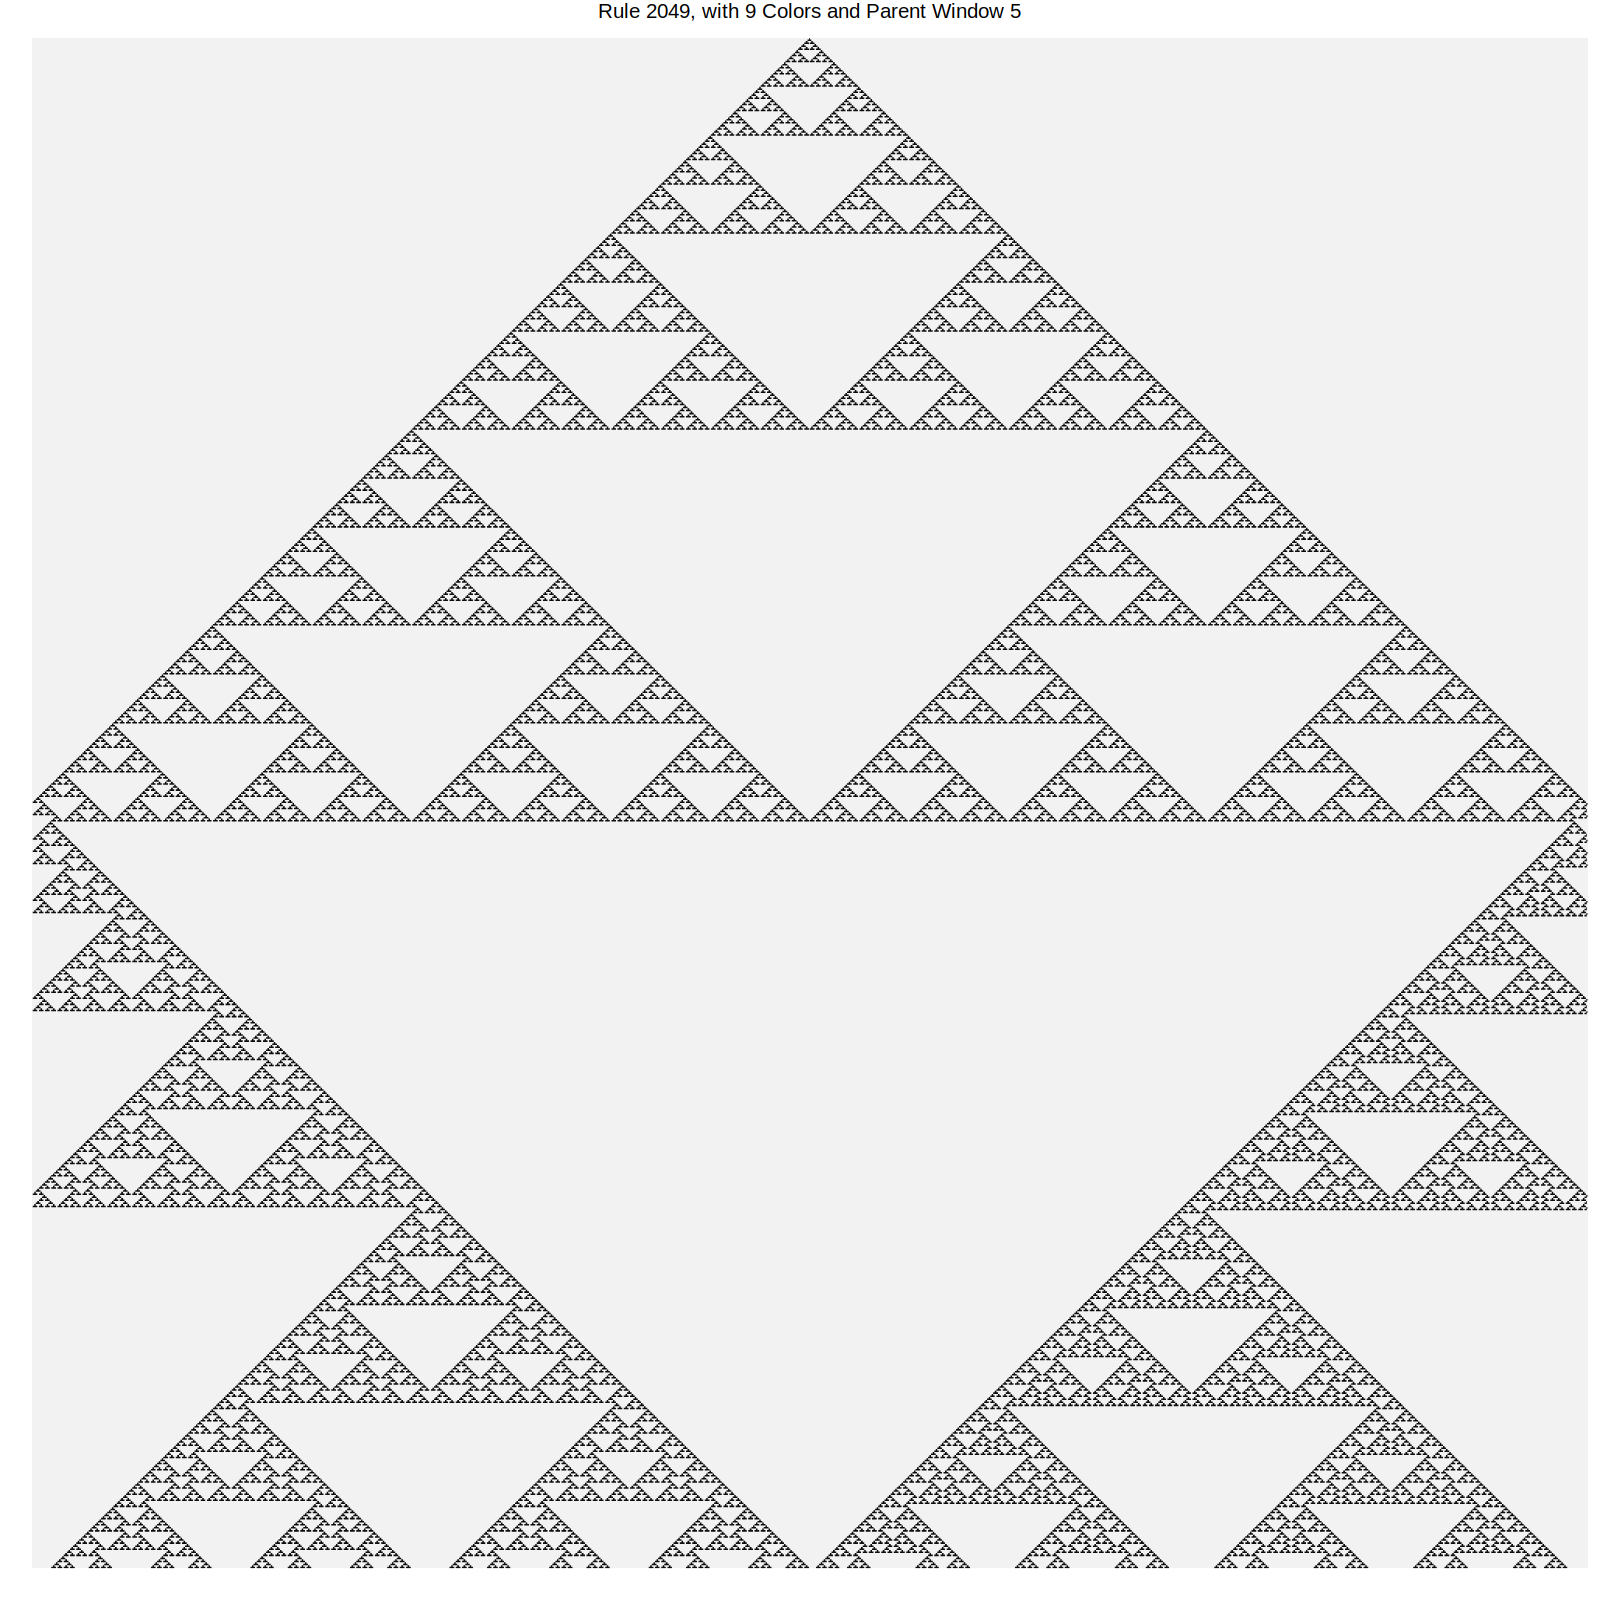

In [55]:
p = 2; # parent window 2p+1 = 5
k = 9; # k = 5 colors
autamaton = k_color(2001, 1000, 90, p, k);
heatmap(1:size(autamaton,2),
    1:size(autamaton,1),
    reverse(autamaton, dims=1),
    c = :grays,
    axis=([], false),
    legend=false,
    size=(1600, 1600),
    title="Rule 2049, with $k Colors and Parent Window $(2*p+1)")

# Mobile Automata

